# Microsoft Malware Prediction competition on Kaggle

Link to the competition website: https://www.kaggle.com/c/microsoft-malware-prediction

In [1]:
#!/usr/bin/python
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

#import standard ML libraries
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


#import specific classifiers
from sklearn.ensemble import RandomForestClassifier
print('Lib import check positive ++.')

Lib import check positive ++.


C:\Users\Lorenz\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


**Import the dataset (or a sample of the entire file) and get a feeling for the data:**

In [2]:
#import the data and get a feeling for which columns and data types it contains:
df = pd.read_csv('train.csv',nrows=50000, encoding='utf8', engine='python')
print('='*15 + 'Dataframe column overview: ' + '='*15)
print(df.describe())
print('='*15 + 'Dataframe dimensions: ' + '='*15)
print(df.shape)
print('='*15 + 'All column names: ' + '='*15)
print(df.columns.values)

===============Dataframe column overview: ===============
        IsBeta  RtpStateBitfield  IsSxsPassiveMode  DefaultBrowsersIdentifier  \
count  50000.0      49825.000000      50000.000000                2437.000000   
mean       0.0          6.843532          0.017660                1635.159212   
std        0.0          1.030992          0.131714                 994.265035   
min        0.0          0.000000          0.000000                   1.000000   
25%        0.0          7.000000          0.000000                 788.000000   
50%        0.0          7.000000          0.000000                1632.000000   
75%        0.0          7.000000          0.000000                2290.000000   
max        0.0          8.000000          1.000000                3195.000000   

       AVProductStatesIdentifier  AVProductsInstalled  AVProductsEnabled  \
count               49809.000000         49809.000000       49809.000000   
mean                47841.869000             1.322693       

## Machine Learning:

**Preprocessing:**

In [3]:
#fill all NaN values with a 0.0
# (this assumption may be challenged later on, does not have to be true.)
df = df.fillna(0.0)

#split the data into actual feature data and the target column (in this case "HasDetection")
Y = df[['HasDetections']]
X = df.drop(['HasDetections'],axis=1)

**Take all columns for the ML model:**

In [4]:
#split the data into actual feature data and the target column (in this case "HasDetection")
Y_all_cols = df[['HasDetections']]
X_all_cols = df.drop(['HasDetections'],axis=1)
X_all_cols_list = (list(X_all_cols.columns.values))
print(X_all_cols_list)

['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode', 'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier', 'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm', 'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier', 'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Platform', 'Processor', 'OsVer', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease', 'OsBuildLab', 'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'PuaMode', 'SMode', 'IeVerIdentifier', 'SmartScreen', 'Firewall', 'UacLuaenable', 'Census_MDC2FormFactor', 'Census_DeviceFamily', 'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier', 'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier', 'Census_ProcessorModelIdentifier', 'Census_ProcessorClass', 'Census_PrimaryDiskTotalCapacity', 'Census_PrimaryDiskTypeName', 'Census_SystemVolumeTotalCapacity', 'Census_HasOpticalDiskDrive', 'Census_TotalPhysicalRAM', 'Census_ChassisType

In [5]:
#drop the columns with high variety:
cols_to_drop = ['AvSigVersion','Census_FirmwareVersionIdentifier','CityIdentifier','Census_OEMModelIdentifier','Census_SystemVolumeTotalCapacity','MachineIdentifier']
X_without_large_cols = X.drop(columns=cols_to_drop, axis=1)
#create dummies, split rows with differing values into separate columns:
X_proc= pd.get_dummies(data=X_without_large_cols, columns=list(X_without_large_cols.columns.values))
print(X_proc)

       ProductName_mse  ProductName_win8defender  EngineVersion_1.1.12805.0  \
0                    0                         1                          0   
1                    0                         1                          0   
2                    0                         1                          0   
3                    0                         1                          0   
4                    0                         1                          0   
5                    0                         1                          0   
6                    0                         1                          0   
7                    0                         1                          0   
8                    0                         1                          0   
9                    0                         1                          0   
10                   0                         1                          0   
11                   0                         1    

In [6]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_proc, Y, test_size=0.2) # 80% training and 20% test

In [7]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for classifier:')
    #fig.colorbar(shrink=0.8)
    return fig

Accuracy:  0.601
AUC:  0.6530335704417912


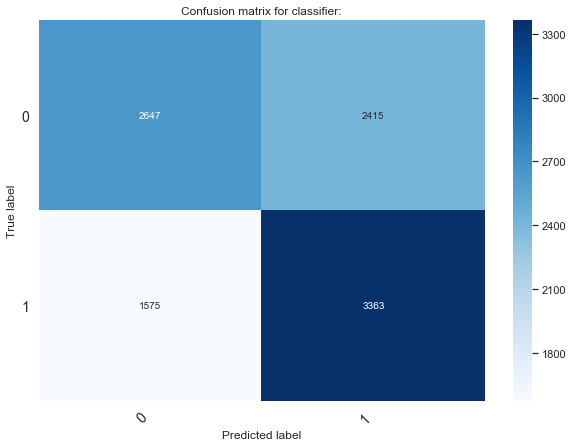

In [8]:
# Create a random forest Classifier. By convention, clf means 'Classifier'
clf = RandomForestClassifier(n_estimators = 400, max_depth=7,n_jobs=3, random_state=0)

# Train the Classifier to take the training features and learn how they relate
# to the training y
clf.fit(X_train, y_train.values.ravel())
#test the classifier's accuracy:
y_pred=clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy: ",metrics.accuracy_score(y_test, y_pred))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
print("AUC: ", auc(false_positive_rate, true_positive_rate))
cm = confusion_matrix(y_test, y_pred)
labels = [0,1]
fig = print_confusion_matrix(cm,labels)

**Let's try with gridsearch CV to get better hyper parameters for the model:**

In [ ]:
rfc=RandomForestClassifier(random_state=42)
param_grid = { 
    'n_estimators': [200,500]
    #,'max_features': ['auto', 'sqrt', 'log2']
     ,'max_depth' : [4,5,6,7,8]
    #,'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid)
CV_rfc.fit(X_train, y_train.values.ravel())